# Object Detection 시스템 만들기
Detection 모델을 학습시키기 위한 전체 파이프라인을 직접 제작하기에는 많은 시간이 들기 때문에 RetinaNet이라는 1-stage detector를 미리 학습시킨 라이브러리를 활용하도록 하겠습니다.

**(주의)**  [RetinaNet 홈페이지](https://github.com/fizyr/keras-retinanet) 에 보면 **tensorflow 2.3.0, tf.keras 2.4.0**을 사용할 것을 권장하며, 그보다 높은 버전에서는 오류가 발생한다고 안내하고 있습니다.
```
$ pip uninstall tensorflow
$ pip install tensorflow==2.3.0
```
프로젝트 디렉토리로 이동합니다. 그 후 다음 리포지토리(repository)를 받고, 리포지토리 사용에 필요한 케라스 라이브러리를 aiffel 가상환경 내에 설치해 줍니다.
```
$ cd ~/aiffel/object_detection
$ git clone https://github.com/fizyr/keras-retinanet.git
$ cd keras-retinanet && python setup.py build_ext —inplace
```
필요사항을 설치하고, keras-retinanet 또한 pip 패키지로 인스톨 해줍니다.
```
$ pip install -r requirements.txt
$ pip install .
```

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

print('=3')

=3


In [2]:
# 다운로드에 매우 긴 시간이 소요됩니다. 
import urllib3
urllib3.disable_warnings()

data_dir = os.path.join(os.getenv("HOME"), "aiffel/object_detection/data")

(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=data_dir,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

print('=3')

=3


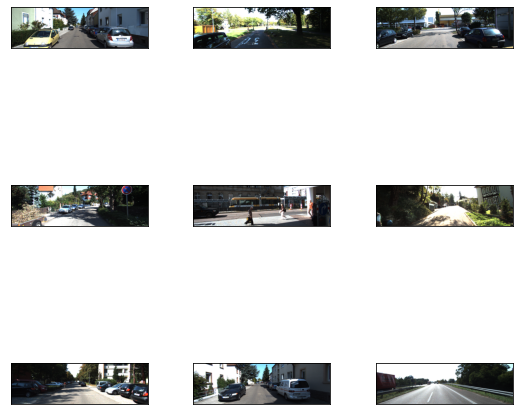

In [3]:
_ = tfds.show_examples(ds_train, ds_info)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(8,), dtype=float32, numpy=
array([-1.75,  2.39,  2.54, -1.21, -1.26,  2.14,  2.72,  1.76],
      dtype=float32)>, 'bbox': <tf.Tensor: shape=(8, 4), dtype=float32, numpy=
array([[0.31176   , 0.5591465 , 0.53098667, 0.6518679 ],
       [0.22274667, 0.8595089 , 0.59493333, 0.99919486],
       [0.33      , 0.7747021 , 0.6758133 , 0.99919486],
       [0.29101333, 0.22861513, 0.42504   , 0.30971014],
       [0.33984   , 0.2735024 , 0.51432   , 0.35524958],
       [0.04029333, 0.        , 0.44781333, 0.21161836],
       [0.41181332, 0.6830676 , 0.60138667, 0.8504187 ],
       [0.41813335, 0.35814816, 0.5188533 , 0.4028261 ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(8, 3), dtype=float32, numpy=
array([[1.55, 1.66, 4.15],
       [1.47, 1.7 , 4.65],
       [1.91, 1.81, 4.33],
       [0.91, 1.32, 2.41],
       [1.63, 1.61, 3.81],
       [1.43, 1.57, 3.48],
       [1.63, 1.67, 4.3

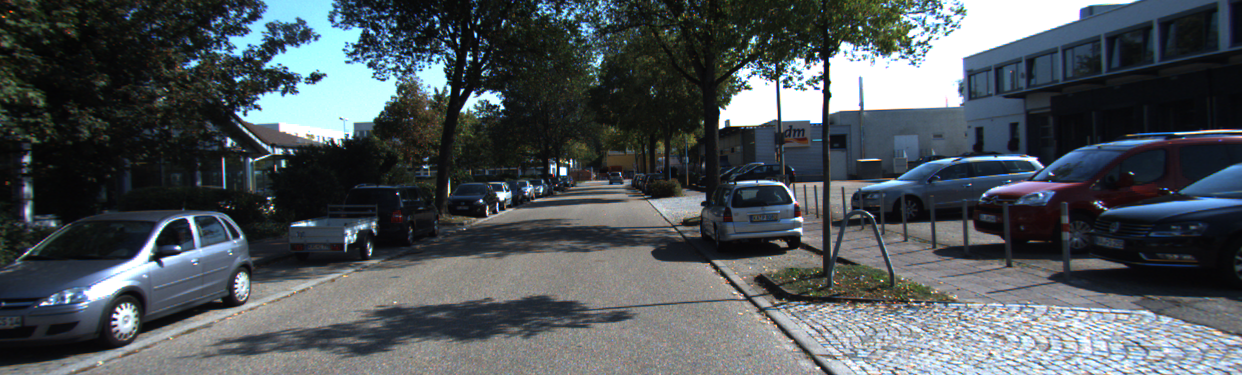

In [5]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
img

width: 1242  height: 375
(8, 4)
[694.45996 258.09    809.61993 175.88   ]
[1067.51  291.47 1241.    151.9 ]
[ 962.18     251.25    1241.       121.57001]
[283.94 265.87 384.66 215.61]
[339.69    247.56    441.21997 182.12999]
[  0.      359.89    262.83002 207.07   ]
[ 848.37  220.57 1056.22  149.48]
[444.82    218.2     500.31003 180.43001]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7F927802D490>


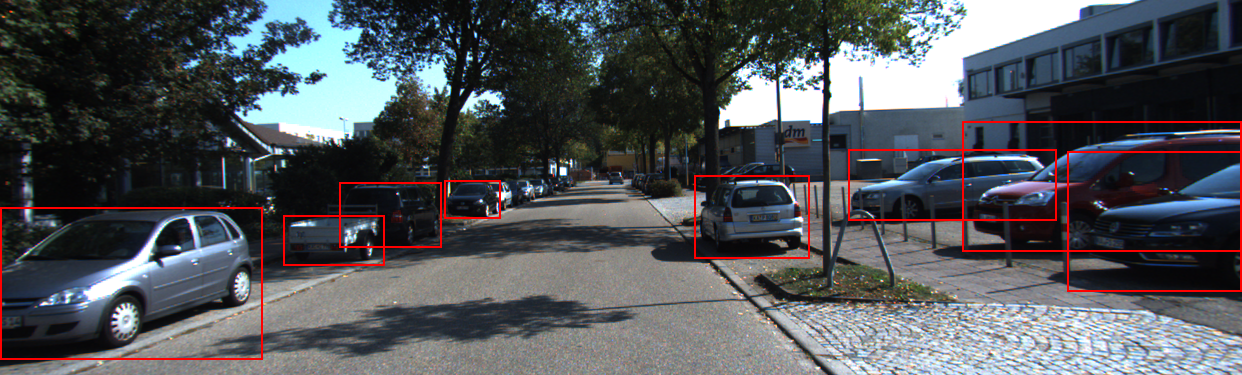

In [6]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print('width:', width, ' height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

In [7]:
import os
data_dir = os.getenv('HOME') + '/aiffel/object_detection/data'
img_dir = data_dir + '/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir, total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 저는 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)
        
        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size
        
        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height
        
        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            
    return df
        
df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',', index=False, header=False)

100%|██████████| 6347/6347 [25:41<00:00,  4.12it/s]


In [8]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',', index=False, header=False)

100%|██████████| 711/711 [02:57<00:00,  4.00it/s]


In [14]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")
    print('Done')
            
save_class_format(class_txt_path)

Done


In [15]:
# RetinaNet 훈련이 시작됩니다!! 10epoch 훈련에 1시간 이상 소요될 수 있습니다. 
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 10 --steps 195 csv data/kitti_train.csv data/classes.txt
print("Done")

2021-10-17 18:58:20.242354: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2021-10-17 18:58:20.242409: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-10-17 18:58:21.994678: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-10-17 18:58:22.004427: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-10-17 18:58:22.004578: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcud

bn4b_branch2b (BatchNormalizati (None, None, None, 2 1024        res4b_branch2b[0][0]             
__________________________________________________________________________________________________
res4b_branch2b_relu (Activation (None, None, None, 2 0           bn4b_branch2b[0][0]              
__________________________________________________________________________________________________
res4b_branch2c (Conv2D)         (None, None, None, 1 262144      res4b_branch2b_relu[0][0]        
__________________________________________________________________________________________________
bn4b_branch2c (BatchNormalizati (None, None, None, 1 4096        res4b_branch2c[0][0]             
__________________________________________________________________________________________________
res4b (Add)                     (None, None, None, 1 0           bn4b_branch2c[0][0]              
                                                                 res4a_relu[0][0]                 
__________

Epoch 1/10
195/195 [==============================] - ETA: 0s - loss: 3.2505 - regression_loss: 2.5838 - classification_loss: 0.6667
Epoch 00001: saving model to ./snapshots/resnet50_csv_01.h5
195/195 [==============================] - 1441s 7s/step - loss: 3.2505 - regression_loss: 2.5838 - classification_loss: 0.6667
Epoch 2/10
195/195 [==============================] - ETA: 0s - loss: 2.3804 - regression_loss: 2.0490 - classification_loss: 0.3314
Epoch 00002: saving model to ./snapshots/resnet50_csv_02.h5
195/195 [==============================] - 1438s 7s/step - loss: 2.3804 - regression_loss: 2.0490 - classification_loss: 0.3314
Epoch 3/10
195/195 [==============================] - ETA: 0s - loss: 2.0644 - regression_loss: 1.7826 - classification_loss: 0.2818
Epoch 00003: saving model to ./snapshots/resnet50_csv_03.h5
195/195 [==============================] - 1436s 7s/step - loss: 2.0644 - regression_loss: 1.7826 - classification_loss: 0.2818
Epoch 4/10
195/195 [=================

In [16]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_10.h5 snapshots/resnet50_csv_10_infer.h5
print("Done")

2021-10-17 22:57:34.945735: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2021-10-17 22:57:34.945791: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-10-17 22:57:36.584563: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-10-17 22:57:36.595193: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-10-17 22:57:36.595354: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcud

In [17]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

dir_path = os.getenv('HOME') + '/aiffel/object_detection/'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_10_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

[192.53795 136.84912 350.0474  234.14455]
[594.70154 176.07826 625.6484  205.32755]
[377.27173 183.17451 417.0159  208.3174 ]
[533.12274 160.33015 563.0797  191.6914 ]


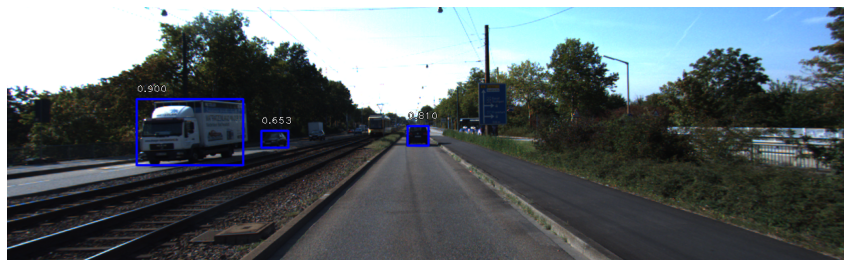

In [18]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path, visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            

inference_on_image(model, img_path)

[776.0371  148.59563 843.71533 313.08783]
[800.2326  149.27246 870.19086 297.95258]


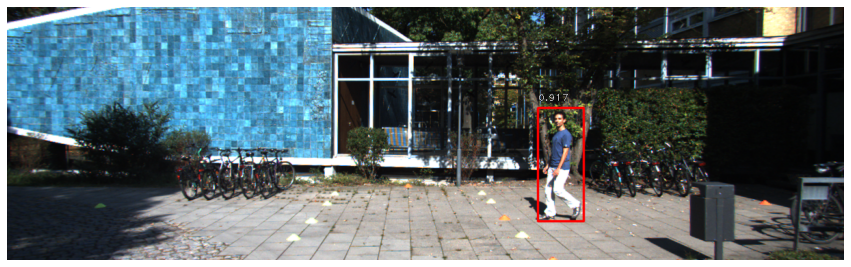

In [19]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
inference_on_image(model, img_path)

[776.0371  148.59563 843.71533 313.08783]
[800.2326  149.27246 870.19086 297.95258]


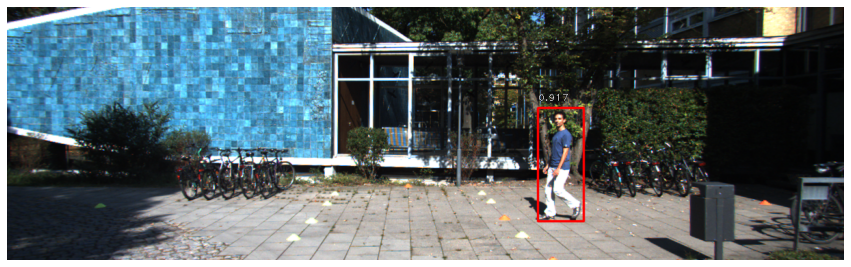

Stop


In [21]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'

def self_drive_assist(model, img_path, size_limit=300):
    image = read_image_bgr(img_path)

    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), 
        1: (255, 0, 0)  
    }

    image = preprocess_image(image)
    image, scale = resize_image(image)

    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    boxes /= scale

    result = 'Go'
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        print(box)
        if score < 0.65:  #0.65 이하는 제외
            break
        b = box.astype(int)
        w = b[2]-b[0]
        h = b[3]-b[1]

        if w >= size_limit or h >= size_limit or label == 1:
            result = 'Stop'
        else:
            result = 'Go'

        draw_box(draw, b, color=color_map[label])

        caption = "{:.3f}".format(score)
        draw_caption(draw, b, caption)
        
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()

    return result

print(self_drive_assist(model, img_path))

[776.0371  148.59563 843.71533 313.08783]
[800.2326  149.27246 870.19086 297.95258]


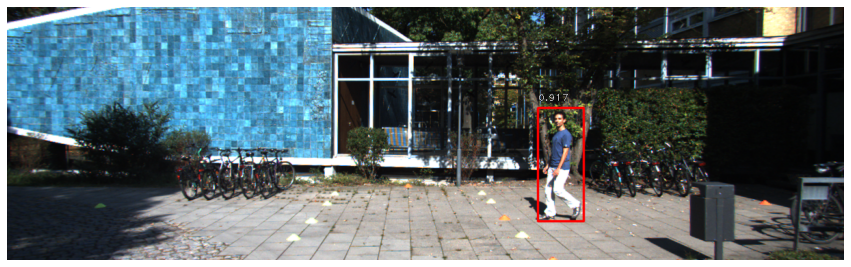

[425.09363 164.84212 500.93765 337.6513 ]
[424.82532 162.27058 501.24908 332.26813]


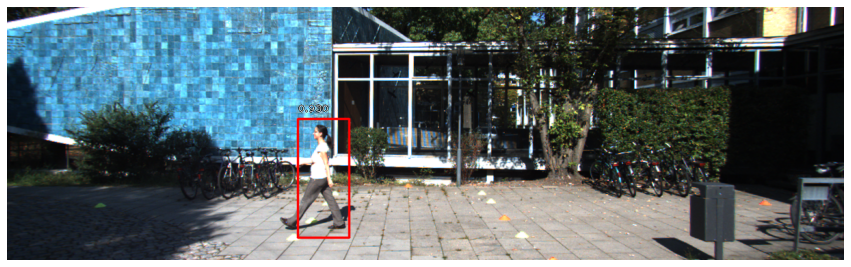

[745.9427  160.42055 883.53784 210.62762]
[  0.      206.96495 297.50024 369.12827]
[ 995.77277  148.7004  1029.1567   220.97098]
[ 986.0252   149.64035 1018.10345  217.62906]


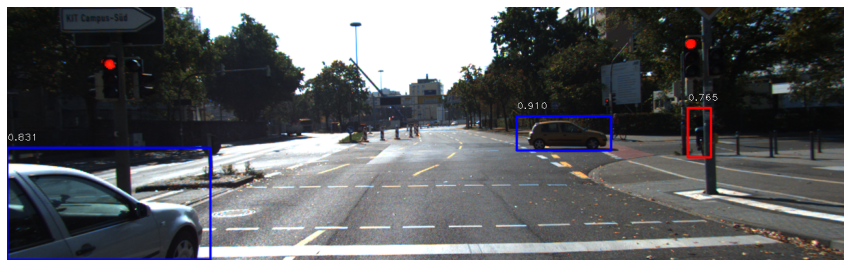

[650.4197  139.18939 739.0096  223.18489]
[429.98    161.88622 550.8157  207.7883 ]
[ 710.6937    99.73271 1093.902    350.97424]
[  8.030926 160.9506   343.33032  310.4172  ]
[341.112   171.6172  478.06107 219.17403]
[379.2298  164.14185 524.3295  213.72198]
[666.2349  138.28732 788.00146 250.99321]


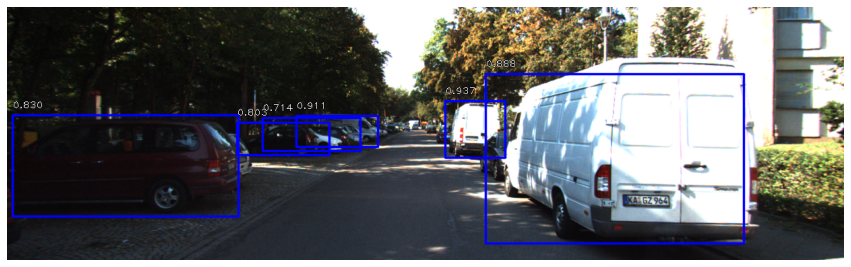

[ 893.0307   189.44398 1241.0684   371.45044]
[738.0911  167.48465 856.5632  247.69917]
[567.9792  181.59166 614.2138  215.69022]
[699.3816  142.93213 776.46893 216.11874]
[718.6296 155.339  824.3295 235.9782]
[697.0571  154.853   751.40533 208.069  ]


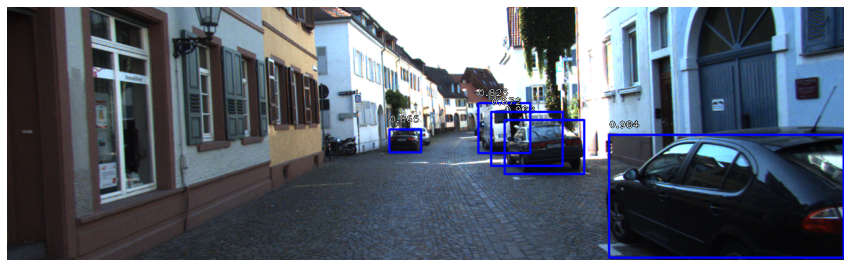

[192.53795 136.84912 350.0474  234.14455]
[594.70154 176.07826 625.6484  205.32755]
[377.27173 183.17451 417.0159  208.3174 ]
[533.12274 160.33015 563.0797  191.6914 ]


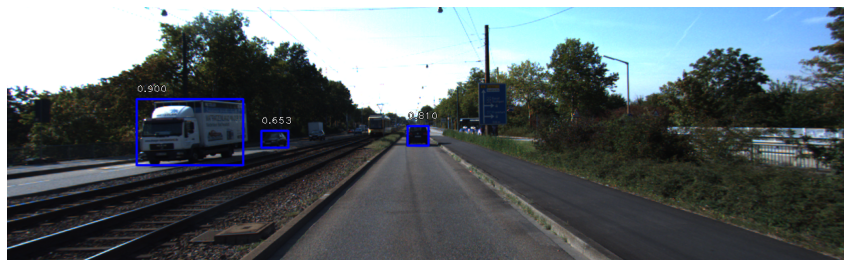

[516.5812  178.18262 569.8114  215.05692]
[627.5603  174.88474 667.18463 213.90678]
[530.218   175.21754 577.75964 205.8489 ]


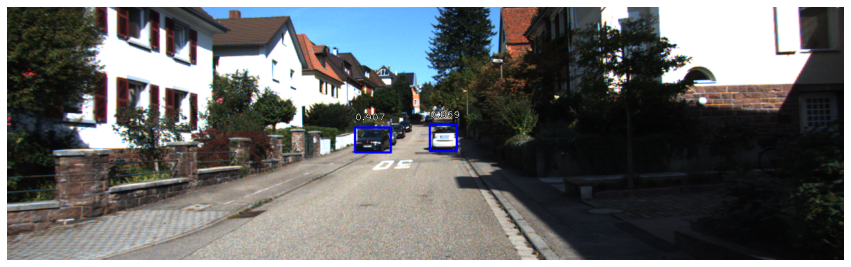

[822.15845 148.53784 882.21747 178.0029 ]
[538.9696  168.00896 570.03125 190.96713]


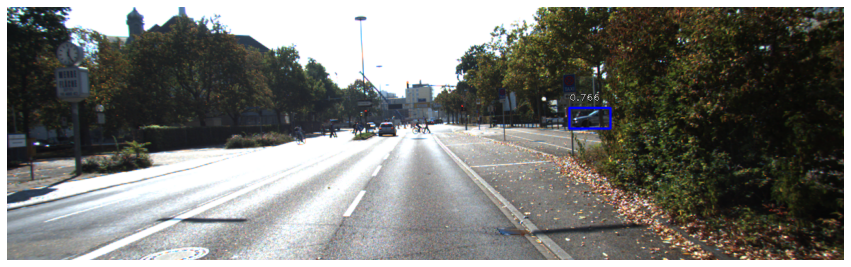

[687.5822  175.37126 797.8168  254.56339]
[677.2937  153.06177 847.0458  258.60834]


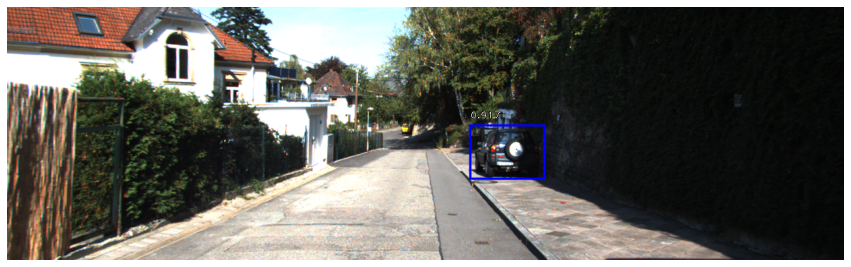

[  0.      188.7672  205.95326 307.49597]
[154.00003 184.22388 338.52246 254.40674]
[326.30478 176.77107 426.50034 223.37057]
[218.2751  176.17609 368.40588 237.62108]
[ 75.90346 186.02072 308.30496 267.63196]
[269.08832 177.28654 390.91144 226.70769]
[441.0434  180.16586 490.01743 209.55904]


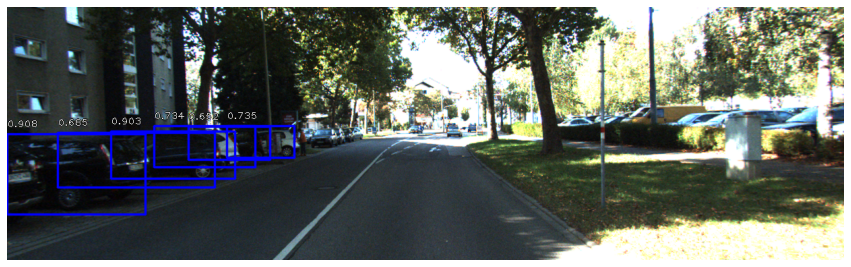

80점입니다.


In [23]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(model, image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)